In [1]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

2023-05-23 20:34:09.474089: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 20:34:09.651269: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-23 20:34:09.651312: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-23 20:34:10.399412: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

In [2]:
lines= pd.read_table('mar.txt', names=['eng', 'mar','Details'])

In [3]:
lines.shape

(46966, 3)

In [4]:
# Lowercase all characters
lines.eng=lines.eng.apply(lambda x: x.lower())
lines.mar=lines.mar.apply(lambda x: x.lower())

In [5]:
# Remove quotes
lines.eng=lines.eng.apply(lambda x: re.sub("'", '', x))
lines.mar=lines.mar.apply(lambda x: re.sub("'", '', x))

In [6]:
exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
lines.eng=lines.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.mar=lines.mar.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [7]:
# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines.eng=lines.eng.apply(lambda x: x.translate(remove_digits))
lines.mar = lines.mar.apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))

In [8]:
# Remove extra spaces
lines.eng=lines.eng.apply(lambda x: x.strip())
lines.mar=lines.mar.apply(lambda x: x.strip())
lines.eng=lines.eng.apply(lambda x: re.sub(" +", " ", x))
lines.mar=lines.mar.apply(lambda x: re.sub(" +", " ", x))

In [9]:
# Add start and end tokens to target sequences
lines.mar = lines.mar.apply(lambda x : 'START_ '+ x + ' _END')

In [10]:
lines.sample(10)

,eng,mar,Details
45123,there is a strange man in front of the house,START_ घरासमोर एक विचित्र माणूस आहे _END,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
37267,what exactly are we looking for,START_ आम्ही नक्की काय शोधत आहोत _END,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
28049,are they talking about you,START_ ते तुमच्याबद्दल बोलत आहेत का _END,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
22952,the waters really nice,START_ पाणी एकदम चांगलं आहे _END,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
46206,if you take this medicine youll feel a lot better,START_ तुम्ही जर हे औषद घेतलंत तर तुम्हाला खूप...,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
40504,i look young compared to my husband,START_ मी माझ्या पतीसमोर तरुण दिसते _END,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
35370,i live next to an old bookshop,START_ मी पुस्तकांच्या एका जुन्या दुकानाच्या ब...,CC-BY 2.0 (France) Attribution: tatoeba.org #7...
34197,my sister is younger than you,START_ माझी बहीण तुझ्यापेक्षा वयाने लहान आहे _END,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
32274,i have to tell tom something,START_ मला टॉमला काहीतरी सांगायचं आहे _END,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
30213,he is much taller than i am,START_ तो माझ्यापेक्षा खूपच उंच आहे _END,CC-BY 2.0 (France) Attribution: tatoeba.org #3...


In [11]:
# Vocabulary of English
all_eng_words=set()
for eng in lines.eng:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

# Vocabulary of French 
all_marathi_words=set()
for mar in lines.mar:
    for word in mar.split():
        if word not in all_marathi_words:
            all_marathi_words.add(word)

In [12]:
# Max Length of source sequence
lenght_list=[]
for l in lines.eng:
    lenght_list.append(len(l.split(' ')))
max_length_src = np.max(lenght_list)
max_length_src

34

In [13]:
# Max Length of target sequence
lenght_list=[]
for l in lines.mar:
    lenght_list.append(len(l.split(' ')))
max_length_tar = np.max(lenght_list)
max_length_tar

37

In [14]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_marathi_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_marathi_words)
num_encoder_tokens, num_decoder_tokens

(5847, 14410)

In [15]:
num_decoder_tokens += 1 #for zero padding
num_encoder_tokens = num_encoder_tokens + 1

In [16]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [17]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [18]:
lines = shuffle(lines)
lines.head(10)

,eng,mar,Details
45543,tom called me yesterday at nine in the morning,START_ टॉमने काल मला सकाळी नऊ वाजता बोलवलं _END,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
9397,tom works at home,START_ टॉम घरी काम करतो _END,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
27482,tom is one of my students,START_ टॉम माझा एक विद्यार्थी आहे _END,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
45456,i thought you were going to wear your new suit,START_ माझा असा विचार होता की तुम्ही तुमचा नवी...,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
19516,are these bananas ripe,START_ ही केळी पिकली आहेत का _END,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
17924,i urgently need a job,START_ मला तातडीने नोकरीची गरज आहे _END,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
22924,the engine doesnt work,START_ इंजिन चालत नाही _END,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
23516,what are we going to do,START_ आपण काय करणार आहोत _END,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
29196,the meeting started at ten,START_ मीटिंग दहा वाजता सुरू झाली _END,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1527,get my rifle,START_ माझी रायफल आण _END,CC-BY 2.0 (France) Attribution: tatoeba.org #1...


In [19]:
# Train - Test Split
X, y = lines.eng, lines.mar
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train.shape, X_test.shape

((37572,), (9394,))

In [22]:
X_train.to_pickle('X_train_mar.pkl')
X_test.to_pickle('X_test_mar.pkl')

In [23]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [24]:
## Encoder - Decoder Model Architecture

In [25]:
latent_dim = 50

In [26]:
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

2023-05-23 20:35:51.745669: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-23 20:35:51.745705: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-23 20:35:51.745730: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (csis-ProLiant-DL380-Gen10): /proc/driver/nvidia/version does not exist
2023-05-23 20:35:51.746092: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [28]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [30]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 50

In [31]:
%%time
history = model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

/home/sunil/sunil2_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/50
293/293 [==============================] - 335s 1s/step - loss: 7.1231 - acc: 0.1748 - val_loss: 6.3431 - val_acc: 0.1753
Epoch 2/50
293/293 [==============================] - 324s 1s/step - loss: 6.2943 - acc: 0.1757 - val_loss: 6.2296 - val_acc: 0.1753
Epoch 3/50
293/293 [==============================] - 323s 1s/step - loss: 6.1629 - acc: 0.1757 - val_loss: 6.1224 - val_acc: 0.1753
Epoch 4/50
293/293 [==============================] - 325s 1s/step - loss: 5.9987 - acc: 0.1758 - val_loss: 5.8824 - val_acc: 0.1790
Epoch 5/50
293/293 [==============================] - 323s 1s/step - loss: 5.7258 - acc: 0.2044 - val_loss: 5.6187 - val_acc: 0.2167
Epoch 6/50
293/293 [==============================] - 324s 1s/step - loss: 5.5251 - acc: 0.2257 - val_loss: 5.4762 - val_acc: 0.2321
Epoch 7/50
293/293 [==============================] - 324s 1s/step - loss: 5.4046 - acc: 0.2355 - val_loss: 5.3843 - val_acc: 0.2373
Epoch 8/50
293/293 [==============================] - 324s 1s/step - 

In [32]:
model.save('MT_Eng_Mar.h5')

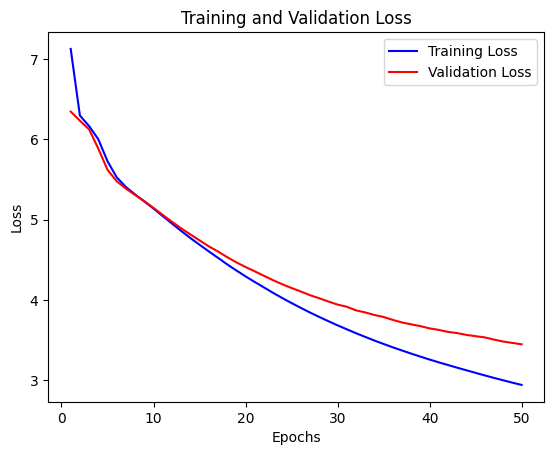

In [33]:
# Get the training and validation loss values
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
# Plot the loss curve
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [34]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)


In [35]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [36]:
import sacrebleu
def calculate_bleu(reference, hypothesis):
    bleu = sacrebleu.corpus_bleu(hypothesis, [reference])
     # Print the BLEU score
    x = bleu.score/100
    print("BLEU Score:",x) 

In [37]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [38]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
reference = y_train[k:k+1].values[0][6:-4]
reference = [reference]
print('Actual Marathi Translation:', reference)
predicted = decoded_sentence[:-4]
predicted = [predicted]
print('Predicted Marathi Translation:', predicted)
calculate_bleu(reference, predicted)

1/1 [==============================] - 0s 24ms/step
Input English sentence: im home almost every night
Actual Marathi Translation: [' मी जवळजवळ प्रत्येक रात्री घरी असते ']
Predicted Marathi Translation: [' मी जवळजवळ घरी फोन करेन ']
BLEU Score: 0.193576934939088


In [40]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
reference = y_train[k:k+1].values[0][6:-4]
reference = [reference]
print('Actual Marathi Translation:', reference)
predicted = decoded_sentence[:-4]
predicted = [predicted]
print('Predicted Marathi Translation:', predicted)
calculate_bleu(reference, predicted)

1/1 [==============================] - 0s 25ms/step
Input English sentence: he was a soldier during the war
Actual Marathi Translation: [' युद्धाच्या वेळी तो सैनिक होता ']
Predicted Marathi Translation: [' तो किती मुलगा होता ']
BLEU Score: 0.1479401567477645


In [41]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
reference = y_train[k:k+1].values[0][6:-4]
reference = [reference]
print('Actual Marathi Translation:', reference)
predicted = decoded_sentence[:-4]
predicted = [predicted]
print('Predicted Marathi Translation:', predicted)
calculate_bleu(reference, predicted)

1/1 [==============================] - 0s 24ms/step
Input English sentence: he did not die of cancer
Actual Marathi Translation: [' ते कर्करोगामुळे मेले नाहीत ']
Predicted Marathi Translation: [' तो आपल्या करतो ']
BLEU Score: 0.0


In [45]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
reference = y_train[k:k+1].values[0][6:-4]
reference = [reference]
print('Actual Marathi Translation:', reference)
predicted = decoded_sentence[:-4]
predicted = [predicted]
print('Predicted Marathi Translation:', predicted)
calculate_bleu(reference, predicted)

1/1 [==============================] - 0s 24ms/step
Input English sentence: i believe tom is right
Actual Marathi Translation: [' माझा विश्वास आहे की टॉम बरोबर आहे ']
Predicted Marathi Translation: [' मी टॉमचा विश्वास आहे ']
BLEU Score: 0.15090767577522726


In [50]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
reference = y_train[k:k+1].values[0][6:-4]
reference = [reference]
print('Actual Marathi Translation:', reference)
predicted = decoded_sentence[:-4]
predicted = [predicted]
print('Predicted Marathi Translation:', predicted)
calculate_bleu(reference, predicted)

1/1 [==============================] - 0s 24ms/step
Input English sentence: i bought two bottles of milk
Actual Marathi Translation: [' मी दुधाच्या दोन बाटल्या विकत घेतल्या ']
Predicted Marathi Translation: [' मी माझ्या भाऊ काम केला ']
BLEU Score: 0.08745825313180626


In [54]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
reference = y_train[k:k+1].values[0][6:-4]
reference = [reference]
print('Actual Marathi Translation:', reference)
predicted = decoded_sentence[:-4]
predicted = [predicted]
print('Predicted Marathi Translation:', predicted)
calculate_bleu(reference, predicted)

1/1 [==============================] - 0s 24ms/step
Input English sentence: weve run out of coffee
Actual Marathi Translation: [' कॉफी संपली आहे ']
Predicted Marathi Translation: [' मला आता जायचं आहे ']
BLEU Score: 0.1597357760615681
